In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pickle

In [109]:
df = pd.read_csv('milano_house_prices_raw_data_cleaned.csv', index_col=0)

Data Preparation

In [110]:
# Selecting columns for model building
df_model = df[['price_euro', 'number_rooms', 'area_m2', 'bathrooms', 'condominium fees', 'neighborhood']]
df_model.head()

,price_euro,number_rooms,area_m2,bathrooms,condominium fees,neighborhood
0,289000.0,3,100,1,250.0,Baggio
1,398000.0,2,78,1,208.0,Argonne - Corsica
2,420000.0,3,85,1,180.0,Crescenzago
3,780000.0,3,80,1,83.0,Porta Romana - Medaglie d'Oro
4,395000.0,2,50,1,80.0,Porta Vittoria


In [111]:
# Drop null values
df_model.isnull().sum()

price_euro          0
number_rooms        0
area_m2             0
bathrooms           0
condominium fees    6
neighborhood        0
dtype: int64

In [112]:
df_model.dropna(axis=0, inplace=True)
df_model.isnull().sum()

C:\Users\amras\AppData\Local\Temp\ipykernel_19352\1810750224.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model.dropna(axis=0, inplace=True)


price_euro          0
number_rooms        0
area_m2             0
bathrooms           0
condominium fees    0
neighborhood        0
dtype: int64

In [113]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1610 entries, 0 to 1615
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price_euro        1610 non-null   float64
 1   number_rooms      1610 non-null   int64  
 2   area_m2           1610 non-null   int64  
 3   bathrooms         1610 non-null   int64  
 4   condominium fees  1610 non-null   float64
 5   neighborhood      1610 non-null   object 
dtypes: float64(2), int64(3), object(1)
memory usage: 88.0+ KB


In [114]:
df_model.shape

(1610, 6)

<Axes: >

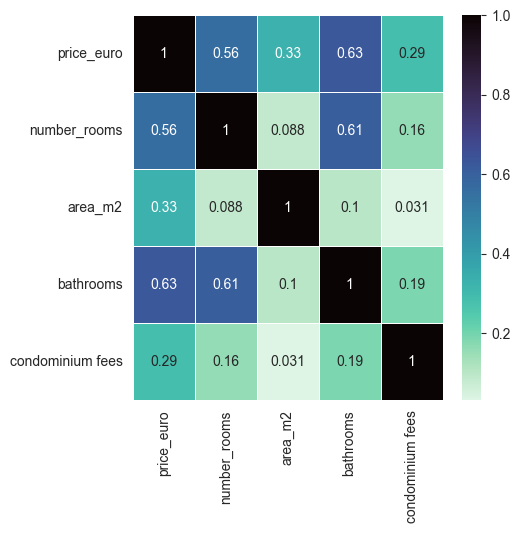

In [115]:
# Check the correlation
correlation = df_model.select_dtypes('number').corr()
_, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(correlation, ax=ax, annot=True, linewidths=0.5, cmap='mako_r') # Number of rooms and bathrooms have a high correlation with the price

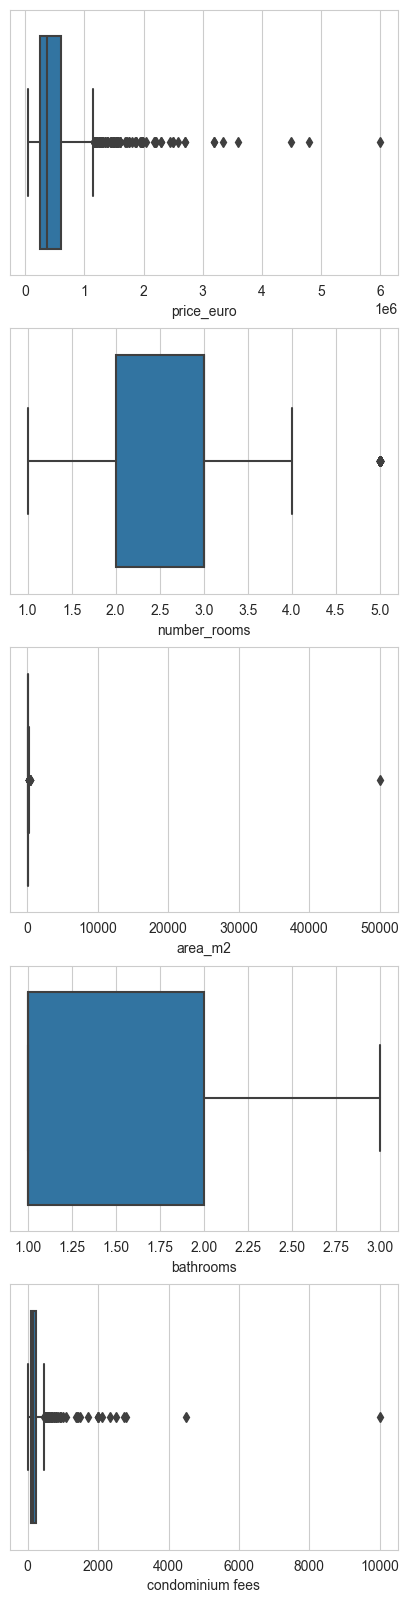

In [116]:
# Dealing with outliers
columns = df_model.select_dtypes('number').columns

# Plot boxplot of each feature
_, ax = plt.subplots(5, figsize=(5,20))
for index, value in enumerate(columns):
    sns.boxplot(data=df_model , x=value, ax=ax[index]) # (Price_euro, condominium fees, number_rooms, area_m2) fees have alot of outliers

In [117]:
df_model.columns

Index(['price_euro', 'number_rooms', 'area_m2', 'bathrooms',
       'condominium fees', 'neighborhood'],
      dtype='object')

In [118]:
# Removing outliers
# I'll remove the outliers by removing rows that contains data bigger than (1.5 * iqr + 3rd quartile)
mask1 = df_model['price_euro'] < iqr(df_model['price_euro']) * 1.5 + np.percentile(df_model['price_euro'], 75)
mask2 = df_model['number_rooms'] < iqr(df_model['number_rooms']) * 1.5 + np.percentile(df_model['number_rooms'], 75)
mask3 = df_model['area_m2'] < iqr(df_model['area_m2']) * 1.5 + np.percentile(df_model['area_m2'], 75)
mask4 = df_model['condominium fees'] < iqr(df_model['condominium fees']) * 1.5 + np.percentile(df_model['condominium fees'], 75)

# DataFrame after removing outliers
df_model = df_model[mask1 & mask2 & mask3 & mask4]

In [119]:
df_model.shape

(1434, 6)

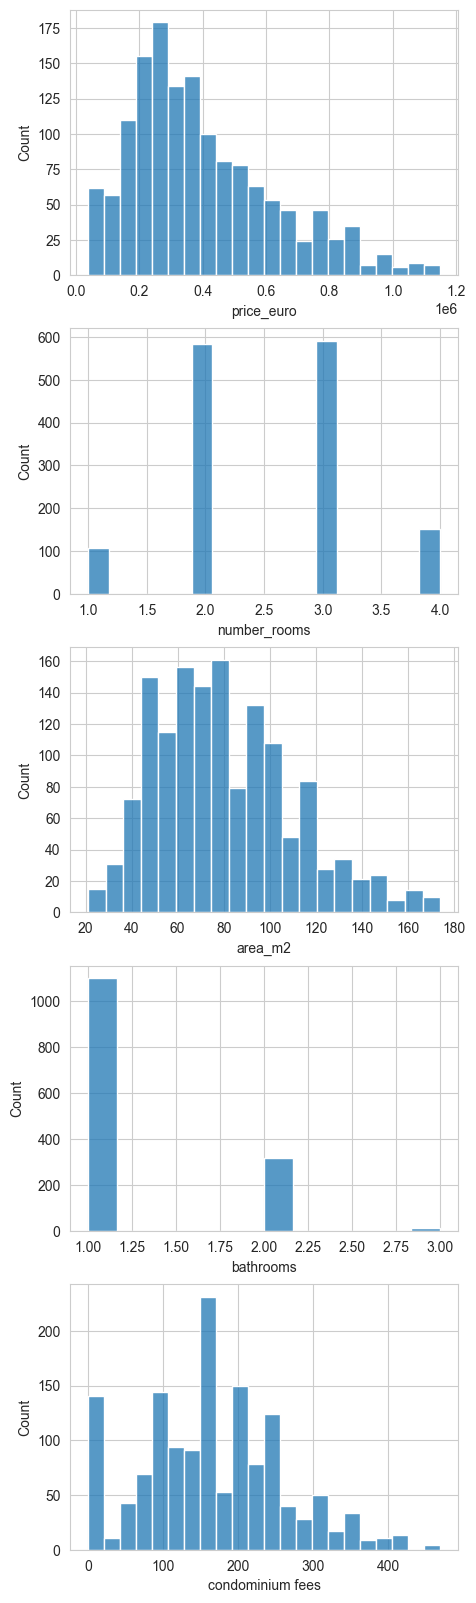

In [120]:
# Dealing with skewed data

# Data is symmetrical: skewness is between -0.5 and 0.5
# Data is slightly skewed: skewness is between -1 and -0.5 or 0.5 and 1
# Data is highly skewed: skewness is less than -1 or greater than 1

# Plot boxplot of each feature
fig, ax = plt.subplots(5, figsize=(5,20))
for index, value in enumerate(columns):
    sns.histplot(data=df_model , x=value, ax=ax[index])

In [121]:
df_model[['price_euro', 'area_m2', 'condominium fees']].skew() # Skewness is in acceptable ranges

price_euro          0.876849
area_m2             0.675003
condominium fees    0.286117
dtype: float64

In [122]:
df_model.index = range(df_model.shape[0])

Data Preprocessing

In [123]:
# Split the data to features and target
target = df_model['price_euro'].copy()
df_model.drop('price_euro', axis=1, inplace=True)

In [124]:
df_model

,number_rooms,area_m2,bathrooms,condominium fees,neighborhood
0,3,100,1,250.0,Baggio
1,2,78,1,208.0,Argonne - Corsica
2,3,85,1,180.0,Crescenzago
3,3,80,1,83.0,Porta Romana - Medaglie d'Oro
4,2,50,1,80.0,Porta Vittoria
...,...,...,...,...,...
1429,2,45,1,100.0,Vialba
1430,3,90,2,208.0,Giambellino
1431,2,54,1,100.0,Vialba
1432,2,50,1,40.0,Porta Romana - Medaglie d'Oro


In [125]:
# Encode categorical features
neighborhoods = pd.get_dummies(df_model['neighborhood'], dtype='int')
neighborhoods

,Affori,Amendola - Buonarroti,Arco della Pace,Argonne - Corsica,Ascanio Sforza,Baggio,Bande Nere,Barona,Bicocca,Bignami - Ponale,...,Turro,Udine,Vercelli - Wagner,Vialba,Viale Ungheria - Mecenate,Vigentino - Fatima,Villa San Giovanni,Vincenzo Monti,Washington,Zara
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1431,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [126]:
# Scale numerical features
scaler = StandardScaler()
data = scaler.fit_transform(df_model.drop('neighborhood', axis=1))
data = pd.DataFrame(data, columns=df_model.drop('neighborhood', axis=1).columns)
data

,number_rooms,area_m2,bathrooms,condominium fees
0,0.579758,0.660318,-0.537919,0.897647
1,-0.703225,-0.072445,-0.537919,0.455514
2,0.579758,0.160707,-0.537919,0.160759
3,0.579758,-0.005830,-0.537919,-0.860359
4,-0.703225,-1.005053,-0.537919,-0.891940
...,...,...,...,...
1429,-0.703225,-1.171590,-0.537919,-0.681400
1430,0.579758,0.327244,1.691490,0.455514
1431,-0.703225,-0.871823,-0.537919,-0.681400
1432,-0.703225,-1.005053,-0.537919,-1.313019


In [127]:
# Concatenate the two dataframes
df_prepared = pd.concat([data, neighborhoods], axis=1)
df_prepared

,number_rooms,area_m2,bathrooms,condominium fees,Affori,Amendola - Buonarroti,Arco della Pace,Argonne - Corsica,Ascanio Sforza,Baggio,...,Turro,Udine,Vercelli - Wagner,Vialba,Viale Ungheria - Mecenate,Vigentino - Fatima,Villa San Giovanni,Vincenzo Monti,Washington,Zara
0,0.579758,0.660318,-0.537919,0.897647,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,-0.703225,-0.072445,-0.537919,0.455514,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.579758,0.160707,-0.537919,0.160759,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.579758,-0.005830,-0.537919,-0.860359,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.703225,-1.005053,-0.537919,-0.891940,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,-0.703225,-1.171590,-0.537919,-0.681400,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1430,0.579758,0.327244,1.691490,0.455514,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1431,-0.703225,-0.871823,-0.537919,-0.681400,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1432,-0.703225,-1.005053,-0.537919,-1.313019,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(df_prepared, target, test_size=0.2, random_state=42)

In [129]:
print(f'Size of train data: {X_train.shape[0]}\nSize of test data: {X_test.shape[0]}')

Size of train data: 1147
Size of test data: 287


Model Building

In [130]:
# Function used to train each model and measure the performance of the model
def try_model(model, X, y):
    model = model
    model.fit(X, y)
    housing_predictions = model.predict(X)
    model_mse = mean_squared_error(y, housing_predictions)
    model_rmse = np.sqrt(model_mse) # One of the best performance measures for regression problems is root mean squared error
    
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    
    print(f'Rmse on training set: {model_rmse}\n')
    print(f'Rmse on k-fold cv sets:\nScores: {rmse_scores}\nMean: {rmse_scores.mean():.2f}\nStandard deviation: {rmse_scores.std():.2f}')

In [131]:
# I will start by trying some model with default hyperparameter
# Then i will compare between the score on the training set and the validation sets
# To see if the model overfit or underfit

In [132]:
# Linear regression model
lin_reg = LinearRegression()
try_model(lin_reg, X_train, y_train) # The model suffers from a very bad overfitting

Rmse on training set: 88280.62782705881

Rmse on k-fold cv sets:
Scores: [1.04658451e+17 1.06091669e+05 3.03114150e+16 7.30110146e+16
 8.16835789e+15]
Mean: 43229847632518064.00
Standard deviation: 39813075429865824.00


In [133]:
# Support Vector Regressor model
svm_reg = SVR(kernel="linear")
try_model(svm_reg, X_train, y_train) # The model suffers from a very bad underfitting

Rmse on training set: 232437.33610471358

Rmse on k-fold cv sets:
Scores: [212432.88960909 216678.99218241 243118.30117587 244425.42205235
 245285.0109901 ]
Mean: 232388.12
Standard deviation: 14637.97


In [134]:
# Decision Tree model
tree_reg = DecisionTreeRegressor(random_state=42)
try_model(tree_reg, X_train, y_train) # The model suffers from a very bad overfitting

Rmse on training set: 10594.156159364615

Rmse on k-fold cv sets:
Scores: [161377.01224651 147860.06182196 154868.17989871 175581.84174449
 161470.21472207]
Mean: 160231.46
Standard deviation: 9168.39


In [135]:
# Random Forest model
forest_reg = RandomForestRegressor(random_state=42)
try_model(forest_reg, X_train, y_train) # The model suffers from a very bad overfitting

Rmse on training set: 48802.42441658406

Rmse on k-fold cv sets:
Scores: [124552.17757812 126983.86667855 127379.5126914  139770.28678188
 133940.08748417]
Mean: 130525.19
Standard deviation: 5572.19


In [136]:
# Fine-tune the random forest using GridSearchCV()  model because it seems optimistic
params_grid = {'n_estimators':range(10,300,10), 'max_features':('auto','sqrt','log2')}

random_forest = RandomForestRegressor()

grid_search = GridSearchCV(random_forest,
                           params_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           verbose=3)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

Fitting 5 folds for each of 87 candidates, totalling 435 fits
[CV 1/5] END max_features=auto, n_estimators=10;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END max_features=auto, n_estimators=10;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END max_features=auto, n_estimators=10;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END max_features=auto, n_estimators=10;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END max_features=auto, n_estimators=10;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END max_features=auto, n_estimators=20;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END max_features=auto, n_estimators=20;, score=(train=nan, test=nan) total time=   0.0s
[CV 3/5] END max_features=auto, n_estimators=20;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END max_features=auto, n_estimators=20;, score=(train=nan, test=nan) total time=   0.0s
[CV 5/5] END max_features=auto, n_estimators=20;, score=(train=na

C:\Users\amras\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
145 fits failed out of a total of 435.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
145 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\amras\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\amras\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\amras\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base

{'max_features': 'log2', 'n_estimators': 250}


Evaluate on the Test Set

In [137]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [138]:
final_rmse

112686.28371784648

Saving the model

In [139]:
pickl = {
    'model' : final_model
}
pickle.dump(pickl, open('model_file' + '.p', 'wb'))

In [140]:
file_name = 'model_file.p'
with open(file_name, 'rb') as pickled:
    data = pickle.load(pickled)
    model = data['model']
model

RandomForestRegressor(max_features='log2', n_estimators=250)

Make some prediction

In [141]:
# Getting the mean of the condominium fees of each neighborhood
means = df.groupby('neighborhood')['condominium fees'].mean()

# Function to predict the prices
def price_prediction(number_rooms,area_m2,bathrooms, neighborhood):    
    loc_index = np.where(df_prepared.columns == neighborhood.capitalize())[0][0] # To get the column number for the corresponding neighborhood

    x = np.zeros(len(df_prepared.columns)) # To make a zero-array with the same length as the number of columns
    x[0] = number_rooms
    x[1] = area_m2
    x[2] = bathrooms
    x[3] = means[neighborhood.capitalize()] # fill the condominium fees with the average value of each neighborhood
    if loc_index >= 0:
        x[loc_index] = 1

    return model.predict([x])[0]

In [144]:
price_prediction(3, 250, 2, 'duomo')

C:\Users\amras\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


785973.6